# Кластеризация
Внутри класстера, объекты похожи друг на друга, а объекты разных кластеров должны существенно отличаться

## K-means
Центроиды получают случайное положение при старте обучения модели, а после расчитывают расстояние до ближайших точек
и ищут положение, в котором расстояние до всех ближайших точек минимально
K - число кластеров, их всегда больше 2

In [3]:
from scipy.spatial.distance import euclidean

In [7]:
c1 = [1.0, 1.5]
c2 = [-1.0, -0.5]

dist = euclidean(c1, c2)
print(dist)

2.8284271247461903


Алгоритм повторяет до тех пор, пока:
* Алгоритм сошёлся (центроиды не меняют своё положение)
* Превышено количество итераций
* Алгоритм не сошёл, объекты нельзя кластеризировать данным количеством центроидов

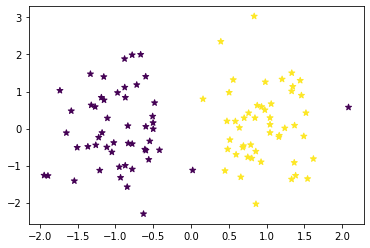

In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open('clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)
    
X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])
plt.scatter(X[:, 0], X[:, 1], s=40, marker='*', c=Y)
plt.show()

C:\Users\He11scream\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


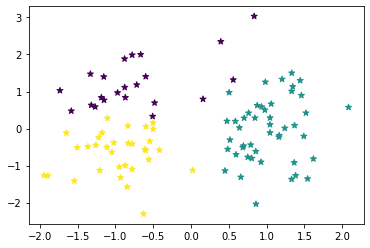

In [41]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=3, random_state=32)
kmean.fit(X)

plt.scatter(X[:, 0], X[:, 1], s=40, marker='*', c=kmean.labels_)
plt.show()

## Недостатки
* Вычислительная сложность - чем больше объектов, тем дольше будет вычисляться расстояние
**Решение: Mini Batch K-means**
* Где лучше центрелизировать центроиды? От начального положения зависит сколько времени потребуется для построения модели
**Решение: запускать алгоритм несколько раз и смотреть, где сошёлся алгоритм. После нескольких запусков, надо усреднить
результаты всех центроидов - это и будет решение.**

In [27]:
from sklearn.metrics.pairwise import euclidean_distances

metrics = []
MAX_CLUSTERS = 7

for cluster_num in range(2, MAX_CLUSTERS):
    kmean = KMeans(n_clusters=cluster_num, random_state=99).fit(X)
    centroids, labels = kmean.cluster_centers_, kmean.labels_
    metric = 0
    for centroid_label in range(cluster_num):
        metric += euclidean_distances(
        X[labels==centroid_label],
        centroids[centroid_label, :].reshape(1, -1)
        ).sum(axis=0)[0]
    print("cluster_num %d metric %.2f" %(cluster_num, metric))
    metrics.append(metric)

cluster_num 2 metric 92.34
cluster_num 3 metric 74.52
cluster_num 4 metric 60.75
cluster_num 5 metric 54.87
cluster_num 6 metric 49.75


C:\Users\He11scream\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\He11scream\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\He11scream\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\He11scream\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

## Алгоритм DBScan
Основан на плотности точек, похож на KNeighbors - ищет ближайших соседей
**DBSCAN (Density-based spatial clustering of applications with noise, плотностной алгоритм пространственной кластеризации с присутствием шума)**
Принимает на вход 2 параметра:
* Радиус окрестности, в котором мы ищем соседей каждой точки
* Пороговое значение k количества соседей внутри радиуса

**Оба этих параметра подбираются на валидационной выборке с помощью процедуры GridSearch**

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open('clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)
    
X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

In [29]:
from sklearn.cluster import DBSCAN
#eps - радиус окружности, в которой будут искаться соседи, min_samples - количество соседей. Оба параметр обязательные
db = DBSCAN(eps=0.6, min_samples=10).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

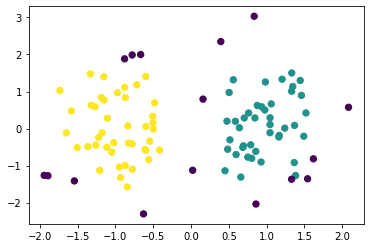

In [30]:
labels = db.labels_
plt.scatter(X[:, 0], X[:, 1], s=40, c=labels, marker='o')
plt.show()

In [31]:
#DBScan нашёл 2 кластера, а остальные точки определил как выбросы. В этом его преимущество перед K-means
#он не пытается определить каждую точку к какому-то кластеру. Так проще искать выбросы.

## Метрики качества кластеризации

### Коэффицент силуэт - это метрика, которая не предполагает знания истинных меток объектов,
### а поэтому позволяет оценить качество кластеризации, используя только саму (неразмеченную выборку) и результат кластеризации. 
### Интуитивное описание метрики:
* Точки внутри кластера должны лежать очень близко друг к другу, то есть кластер должен быть плотным
* Сами кластеры должны лежать как можно дальше друг от друга

### Значения от -1 до 1. -1 - кластеры плохие, размытые. 0 - кластеры накладываются друг на друга, 1 - кластеры плотные. Хорошими считаются кластеры со значением выше 0.5

In [32]:
#вычисляем метрику силуэта
from sklearn.metrics import silhouette_score

In [33]:
score = silhouette_score(X, db.labels_)
print("Качество кластеризации по метрике силуэтта %.3f"%score)

Качество кластеризации по метрике силуэтта 0.371


In [42]:
score = silhouette_score(X, kmean.labels_)
print("Качество кластеризации по метрике силуэтта %.3f"%score)

Качество кластеризации по метрике силуэтта 0.452


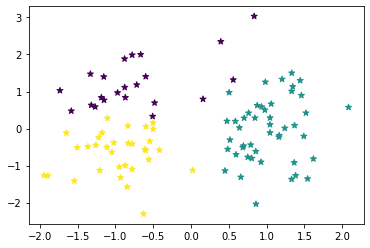

In [44]:
plt.scatter(X[:, 0], X[:, 1], s=40, marker='*', c=kmean.labels_)
plt.show()

### AMI - Скорректированная взаимная информация (Adjusted Mutual Information), подходит когда "истинная метка" кластера нам известна